# Gas Streaming in Disks: circular orbit approach

The gas streaming around a young star, or in a galactic disk is dominated by gravity. So we can simply compute the orbits of a point mass around a star, or in the more complex potential of a galactic disk, where we actually want to discover the mass distribution from the gas (or star) streaming.

If we assume the mass distribution is spherical, we know circular orbits are the simple solution to gas flow or periodic orbits in such a potential. This will allow us to predict the velocity field we are observing in galaxies such as NGC 6503.


In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import math

# Initialize the data


First we need to define a function that tells us the speed of the gas at a given distance from the center of the star or galaxy. We consider only three simple cases here, always based on the balance of gravitation and centrifugal force in a spherical mass distribution:
$$
      { v^2 \over r } = {{ G M(<r) } \over r^2}
$$
or
$$
          v  = \sqrt{  {G M(<r) }  \over r}
$$

Of course this implies (and that's what we eventually want to do) that for a giving rotation curve, $v$, we can find out the mass distribution:
$$
        G M(<r) = v^2 r 
$$

In [3]:
def velocity(radius, model='galaxy'):
    """describe the streaming velocity as function of radius in or around an object
    such as a star or a galaxy.  We usually define the velocity to be 1 at a radius of 1.
    """
    if model == 'star':
        # A star has a keplerian rotation curve. The planets around our sun obey this law.
        if radius == 0.0:
            return 0.0
        else:
            return 1.0/np.sqrt(radius)
    elif model == 'galaxy':
        # Most disk galaxies have a flat rotation curve with a linear slope in the center.
        if radius > 1.0:
            # flat rotation curve outside radius 1.0
            return 1.0
        else:
            # solid body inside radius 1.0, linearly rising rotation curve
            return radius
    elif model == 'plummer':
        # A plummer sphere was an early 1900s description of clusters, and is also not
        # a bad description for the inner portions of a galaxy. You can also view it
        # as a hybrid and softened version of the 'star' and 'galaxy' described above.
        # Note: not quite 1 at 1 yet
        # return  radius / (1+radius*radius)**0.75
        return radius / (0.5+0.5*radius*radius)**0.75
    else:
        return 0.0
        

In [5]:
#model = 'star'
model = 'galaxy'
#model = 'plummer'
rad = np.arange(0.0,4.0,0.05)
vel = np.zeros(len(rad))                   #    this also works: vel = rad * 0.0
for i in range(len(rad)):
    vel[i] = velocity(rad[i],model)
print("First, peak and Last value:",vel[0],vel.max(),vel[-1])

First, peak and Last value: 0.0 1.0 1.0


## Plotting the Rotation Curve

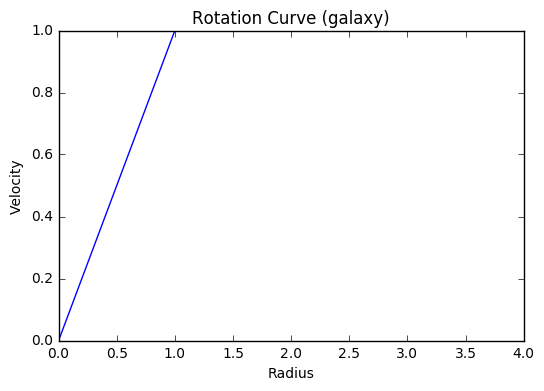

In [6]:
plt.plot(rad,vel)
plt.xlabel("Radius")
plt.ylabel("Velocity")
plt.title("Rotation Curve (%s)" % model);

This curve of velocity as function of radius is called a **Rotation Curve**, and extracting such a curve from an observation is crucial to understanding the mass distribution within a galaxy, or the mass of the young star at the center of the disk. We are assuming the gas is on circular orbits, which turns out is not always correct for galaxies. However, for this experiment we will keep that assumption.

In [7]:
# set the inclination of the disk with the line of sigh 
inc = 60                                      #  (0 means face-on, 90 means edge-on)
#                                                 some helper variables
cosi = math.cos(inc*math.pi/180.0)        
sini = math.sin(inc*math.pi/180.0)
#                                    radius of the disk, and steps in radius
r0 = 4.0
dr = 0.1

## Backwards Projection

This is where we take a point in the sky, and deproject back where in the galaxy this point came from and compute the velocity and projected velocity. The big advantage is the simplicity of computing the observable at each picked point in the sky. The big drawback is that the deprojection may not be trivial in cases where the model is not simple, e.g. non-circular motion and/or non-planar disks. Since we have a simple model here, let's take this approach.  

The so-called forward projection we would need to use some extra steps that only add to the complexity.


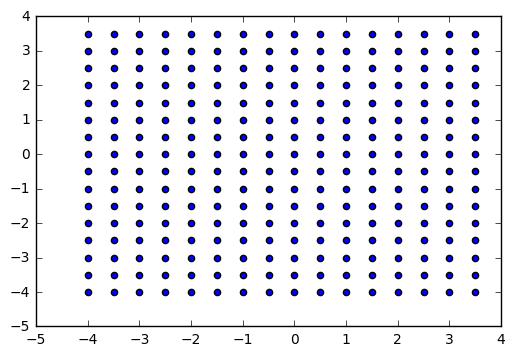

In [8]:
dr = 0.5
x = np.arange(-r0,r0,dr)
y = np.arange(-r0,r0,dr)
xx,yy = np.meshgrid(x,y)                  # helper variables for interpolations
rr = np.sqrt(xx*xx+(yy/cosi)**2)
if r0/dr < 20:
    plt.scatter(xx,yy)
else:
    print("not plotting too many gridpoints/dimension",r0/dr)

Although we have defined a function **velocity** to compute the rotation velocity at any radius, this function cannot easily compute from a numpy array, as we just created on a grid on the sky. Thus we need a convenience function to do just that. 

You could also try and modify the **velocity** function so it takes a numpy array as input, and return a numpy !!!

In [9]:
def velocity2d(rad2d, model):
    """ convenient helper function to take a 2d array of radii
        and return the same-shaped velocities
    """
    (ny,nx) = rad2d.shape
    vel2d = rad2d.copy()         # could also do np.zeros(nx*ny).reshape(ny,nx)
    for y in range(ny):
        for x in range(nx):
            vel2d[y,x] = velocity(rad2d[y,x],model)
    return vel2d

In [10]:
vv = velocity2d(rr,model)
vvmasked = np.ma.masked_where(rr>r0,vv)
vobs = vvmasked * xx / rr * sini
print("V_max:",vobs.max())


V_max: 0.866025403784


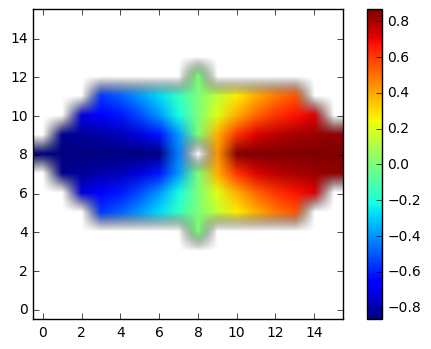

In [11]:
vmax = 1
vmax = vobs.max()
if vmax > 0:
    plt.imshow(vobs,origin=['Lower'],vmin=-vmax, vmax=vmax)
    #plt.matshow(vobs,origin=['Lower'],vmin=-vmax, vmax=vmax)
else:
    plt.imshow(vobs,origin=['Lower'])
plt.colorbar()

This plot will not look very good :

* make the step size in radius (**dr**) small enough.
* select the right plotting range via vmax=
* turn off the interpolation method that is defaulted in imshow().  For enough pixels (or small **dr**) there should be no difference between imshow() and matshow()

## Forward projection

This is the most simple generic method. You describe the model, project it and simply compute the observables (the observed position **x** and **y**, and the radial velocity **v**). You then need to grid these observed points on a sky grid.



In [ ]:
# get random points along a regular series of circles, which describes the model
# we assume the gas is streaming along those circles
radii = np.arange(0.0,r0,dr)
xobs = np.arange(0)
yobs = np.arange(0)
vobs = np.arange(0)
for r in radii:
    vrot = velocity(r,model)
    phi = np.random.random(45)*2*math.pi
    # orbit properties we need
    x  = r*np.cos(phi)
    y  = r*np.sin(phi)
    v  = vrot*np.cos(phi)
    # project
    xobs  = np.append(xobs,x)
    yobs  = np.append(yobs,y*cosi)
    vobs  = np.append(vobs,v*sini)Perhaps you can already see some flaws in this approach. But it's a more general approach to simulate an observation.  We will now do the reverse operation, since the rotation disk is simple to describe.

Now we have a set of (xobs,yobs,vobs) points that need to be gridded on the sky.


In [ ]:
plt.scatter(xobs,yobs,c=vobs)
plt.colorbar()

In [ ]:
plt.scatter(xobs,vobs,c=yobs)
plt.colorbar()

We now have a function *vobs = f(xobs,yobs)*, but defined on an irregular grid *(xobs,yobs)*. Of the many tools that the **scipy** module has, is an interpolation routine, which allows us to re-interpolate this on a regular grid, so it can be displayed as an image, similar to the velocity field we derived from the observations.

In [ ]:
import scipy.interpolate

In [ ]:
f = scipy.interpolate.interp2d(xobs,yobs,vobs,fill_value=0.0,kind='cubic')
xgrid = np.arange(-4.0,4.0,0.1)
ygrid = np.arange(-4.0,4.0,0.1)
zz = f(xgrid,ygrid)
print(zz.shape)
print(len(xobs))
plt.imshow(zz,origin=['Lower'],vmin=-0.5,vmax=0.5)
plt.colorbar()
# so ... this is not working yet

Perhaps you can already see some flaws in this approach. But it's a more general approach to simulate an observation.  We will now do the reverse operation, since the rotation disk is simple to describe.